**OBJECTIVE:** Understand what is the impact on the Y recovered by ViMuReModel when reciprocity on the ground truth Y and mutuality on the X vary?

**LAST UPDATED:** 12/10/2021

In [1]:
import re
import sklearn

import numpy as np
import pandas as pd
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt

import vimure as vm
import vimure.synthetic
import vimure.model

from vimure.plot import plot_adjacency_matrix
from sklearn.metrics import f1_score, mean_absolute_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import make_scorer, mean_squared_error, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

from plotnine import * 
from mizani.formatters import percent_format

In [2]:
# https://stackoverflow.com/a/59812588/843365
!export PYTHONUNBUFFERED=1

# Setup

## Constants

In [3]:
# Parameters related to the ground truth network. 
# Re-run with different seed or parameters to get a different Y

DEFAULT_NUM_REALISATIONS = 10
DEFAULT_MAX_ITER = 101
DEFAULT_GT_PARAMS = {
    "N" : 100,
    "M" : 100, 
    "L" : 1,
    "C" : 2, 
    "K" : 2, 
    "avg_degree" : 10,
    "sparsify" : True}

## Experiment Class

In [4]:
class VaryingReciprocityExp(RegressorMixin, BaseEstimator):
    """
    This class replicates a scikit-learn structure to represent an experiment.

    By extending from sklearn, we can make better use of Grid Search and the library's metrics such as f1-score

    """
    
    def __init__(self, 
                 reciprocity_Y: float = None, 
                 planted_mutuality: float = None, 
                 X_seed: int = None, 
                 Y_seed: int = None, 
                 vimure_seed: int = None, 
                 vimure_mutuality: bool = True, 
                 verbose: bool =False,
                 num_realisations = DEFAULT_NUM_REALISATIONS,
                 max_iter = DEFAULT_MAX_ITER,
                 gt_params: dict = DEFAULT_GT_PARAMS):
        
        self.reciprocity_Y = reciprocity_Y
        self.planted_mutuality = planted_mutuality
        self.X_seed = X_seed
        self.Y_seed = Y_seed
        self.vimure_seed = vimure_seed
        self.vimure_mutuality = vimure_mutuality
        
        self.gt_params = gt_params
        self.num_realisations = num_realisations
        self.max_iter = max_iter
        
        self.verbose = verbose
        self.logger = vm.log.setup_logging("experiment.UnreliableReportersExp", verbose)
     
    def fit(self, X, **fit_params):
        gt_network = vm.synthetic.Multitensor(
            eta=self.reciprocity_Y,
            ExpM=None,
            seed=self.Y_seed,
            **self.gt_params
        )

        gt_network.build_X(
            mutuality=self.planted_mutuality,
            cutoff_X=True,
            seed=self.X_seed,
            flag_self_reporter=True,
            verbose=self.verbose)

        model = vm.model.VimureModel(mutuality=self.vimure_mutuality, verbose=self.verbose)
        model.fit(
            gt_network.X,
            K=gt_network.K,
            seed=self.vimure_seed,
            num_realisations=self.num_realisations,
            max_iter=self.max_iter,
            R=gt_network.R,
            **fit_params
        )
        
        self.network = gt_network
        self.model = model
            
            
    def decision_function(self, X=None):
        """
        Returns the probability that Y==1 as estimated by the model.
        
        The name of this function was not chosen at random. This is a term used everywhere within scikit-learn to
           indicate a soft score for a categorical prediction.
           
        This function is used by GridSearchCV.
           
        See: https://scikit-learn.org/stable/glossary.html#term-decision_function
        """
        # TODO: In the future, add support for multiple layers
        return np.copy(self.model.rho_f[:,:,:,1])[0].flatten()

## Custom Metrics

This follow the same structure as [sklearn custom metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#implementing-your-own-scoring-object) so we can use those latter to run grid search in parallel.

In [5]:
def auc_on_Y(estimator, X, y=None):
    rho_f_flatten = estimator.decision_function() # Represent the probability of getting Y=1
    Y_true = estimator.network.Y[0].flatten()
    return roc_auc_score(Y_true, rho_f_flatten)

def auc_on_X(estimator, X, y=None):
    M_inf = estimator.model.calculate_mean_poisson()
    AUC_X = vm.utils.calculate_AUC(M_inf[0], estimator.network.X[0], mask = estimator.network.R[0])
    return AUC_X

def estimated_eta(estimator, X, y=None):
    return estimator.model.G_exp_nu_f

## F1-scoring functions for predefined thresholds

In [6]:
def custom_f1_scoring_fixed_threshold(estimator, threshold):
    Y_true = estimator.network.Y[0].flatten()
    Y_rec = vm.utils.apply_rho_threshold(estimator.model, threshold).flatten()
    return f1_score(Y_true, Y_rec)   

def custom_f1_scoring_005(estimator, X, y=None):
    return custom_f1_scoring_fixed_threshold(estimator, threshold=0.05)

def custom_f1_scoring_010(estimator, X, y=None):
    return custom_f1_scoring_fixed_threshold(estimator, threshold=0.10)

def custom_f1_scoring_020(estimator, X, y=None):
    return custom_f1_scoring_fixed_threshold(estimator, threshold=0.20)

def custom_f1_scoring_050(estimator, X, y=None):
    return custom_f1_scoring_fixed_threshold(estimator, threshold=0.50)

def custom_f1_scoring_optimal_threshold(estimator, X, y=None):
    Y_true = estimator.network.Y[0].flatten()
    
    Y_rec = vm.utils.apply_rho_threshold(estimator.model).flatten()
    
    return f1_score(Y_true, Y_rec)

## Reciprocity-scoring functions for predefined thresholds

In [7]:
def custom_reciprocity_scoring_fixed_threshold(estimator, threshold):
    Y_rec = vm.utils.apply_rho_threshold(estimator.model, threshold)
    return vm.utils.calculate_overall_reciprocity(Y_rec[0])

def custom_reciprocity_scoring_005(estimator, X, y=None):
    return custom_reciprocity_scoring_fixed_threshold(estimator, threshold=0.05)

def custom_reciprocity_scoring_010(estimator, X, y=None):
    return custom_reciprocity_scoring_fixed_threshold(estimator, threshold=0.10)

def custom_reciprocity_scoring_020(estimator, X, y=None):
    return custom_reciprocity_scoring_fixed_threshold(estimator, threshold=0.20)

def custom_reciprocity_scoring_050(estimator, X, y=None):
    return custom_reciprocity_scoring_fixed_threshold(estimator, threshold=0.50)

def custom_reciprocity_scoring_optimal_threshold(estimator, X, y=None):
    Y_rec = vm.utils.apply_rho_threshold(estimator.model)
    return vm.utils.calculate_overall_reciprocity(Y_rec[0])

def calculate_expected_reciprocity(rho):
    N = rho.shape[1]
    return np.einsum("ij,ji->", rho, rho)/rho.sum()

def metric_expected_reciprocity_posterior(estimator, X, y=None):
    return calculate_expected_reciprocity(estimator.model.rho_f[0,:,:,1])

## Reciprocity-scoring for baselines 

In [8]:
def ground_truth_reciprocity(estimator, X, y=None):
    return vm.utils.calculate_overall_reciprocity(estimator.network.Y[0])

def baseline_union_reciprocity(estimator, X, y=None):
    return vm.utils.calculate_overall_reciprocity(estimator.network.X_union[0])

def baseline_intersection_reciprocity(estimator, X, y=None):
    return vm.utils.calculate_overall_reciprocity(estimator.network.X_intersection[0])

## Heuristic for optimal threshold

In [9]:
def find_optimal_threshold(estimator, X=None):
    """
    This function only works for synthetic networks, for which there is a ground truth.
    """
    
    gt_reciprocity = ground_truth_reciprocity(estimator, None)
    
    previous_diff_to_GT = 0
    curr_diff_to_GT = np.inf
    best_threshold = None
    best_reciprocity = None
    
    for threshold in np.arange(0.05, 0.75, 0.025):
        reciprocity = custom_reciprocity_scoring_fixed_threshold(estimator, threshold)
        
        previous_diff_to_GT = curr_diff_to_GT
        curr_diff_to_GT = abs(reciprocity - gt_reciprocity)
        
        if best_reciprocity is None or (curr_diff_to_GT < previous_diff_to_GT):
            best_reciprocity = reciprocity
            best_threshold = round(threshold, 2)
        
        if curr_diff_to_GT > previous_diff_to_GT:
            break
    return best_threshold

## Network Density

In [10]:
def get_network_density(Y):
    N = Y.shape[0]
    return (Y.sum() - Y[np.arange(N), np.arange(N)].sum())/(N * (N-1))

def custom_net_density_scoring_fixed_threshold(estimator, threshold):
    Y_rec = vm.utils.apply_rho_threshold(estimator.model, threshold)
    return get_network_density(Y_rec[0])

def custom_net_density_scoring_005(estimator, X, y=None):
    return custom_net_density_scoring_fixed_threshold(estimator, threshold=0.05)

def custom_net_density_scoring_010(estimator, X, y=None):
    return custom_net_density_scoring_fixed_threshold(estimator, threshold=0.10)

def custom_net_density_scoring_020(estimator, X, y=None):
    return custom_net_density_scoring_fixed_threshold(estimator, threshold=0.20)

def custom_net_density_scoring_050(estimator, X, y=None):
    return custom_net_density_scoring_fixed_threshold(estimator, threshold=0.50)

def custom_net_density_scoring_optimal_threshold(estimator, X, y=None):
    Y_rec = vm.utils.apply_rho_threshold(estimator.model)
    return get_network_density(Y_rec[0])

def ground_truth_net_density(estimator, X, y=None):
    return get_network_density(estimator.network.Y[0])

def baseline_union_net_density(estimator, X, y=None):
    return get_network_density(estimator.network.X_union[0])

def baseline_intersection_net_density(estimator, X, y=None):
    return get_network_density(estimator.network.X_intersection[0])

def metric_expected_density_posterior(estimator, X, y=None):
    return get_network_density(estimator.model.rho_f[0,:,:,1])

# Dry-run: single experiment

Use the content of this section if you want to try using the experiment for one particular set of parameters, without grid search.

In [11]:
# Parameters that will be part of the experiment

single_run_params = {
    "reciprocity_Y" : 0.2,
    "planted_mutuality" : 0.3,
    "X_seed" : 909,
    "Y_seed" : 32131, 
    "vimure_seed" : 1324210,
    "vimure_mutuality" : True   
}

Run the experiment with the parameters above:

In [12]:
experiment = VaryingReciprocityExp(verbose=True, gt_params=DEFAULT_GT_PARAMS, **single_run_params)
experiment.fit(X=None)

2021-11-04 12:15:06,325 - [PID  854] - vm.model.VimureModel      - DEBUG - Checking user parameters passed to the VimureModel.fit()
2021-11-04 12:15:06,340 - [PID  854] - vm.model.VimureModel      - DEBUG - Initializing priors
2021-11-04 12:15:06,407 - [PID  854] - vm.model.VimureModel      - DEBUG - Realisation  0 | Iter    0 | ELBO value: -1390.579996532152 | Reached convergence: False
2021-11-04 12:15:06,600 - [PID  854] - vm.model.VimureModel      - DEBUG - Realisation  0 | Iter   10 | ELBO value: -967.296445798920 | Reached convergence: False
2021-11-04 12:15:06,801 - [PID  854] - vm.model.VimureModel      - DEBUG - Realisation  0 | Iter   20 | ELBO value: -945.154329639744 | Reached convergence: False
2021-11-04 12:15:07,002 - [PID  854] - vm.model.VimureModel      - DEBUG - Realisation  0 | Iter   30 | ELBO value: -937.967083438199 | Reached convergence: False
2021-11-04 12:15:07,197 - [PID  854] - vm.model.VimureModel      - DEBUG - Realisation  0 | Iter   40 | ELBO value: -934

## Diagnostics

In [14]:
diag_obj = vm.diagnostics.Diagnostics(experiment.model, experiment.network)
diag_obj

---------------
- DIAGNOSTICS -
---------------

Model: ViMuRe(T)

  Priors:
   - eta:    shp=0.50 rte=1.00
   - theta:  shp=0.10 rte=0.10
   - lambda: shp=10.0 rte=10.0
   - rho:    a (1, 100, 100, 2) tensor (to inspect it, run <diag_obj>.model.pr_rho)

  Posteriors:
   - G_exp_lambda_f: [[0.002324   1.55333864]]
   - G_exp_nu_f: 0.32
   - G_exp_theta_f: a (1, 100) tensor (to inspect it, run <diag_obj>.model.G_exp_theta_f)

Optimisation:

   Elbo: -913.948664258133

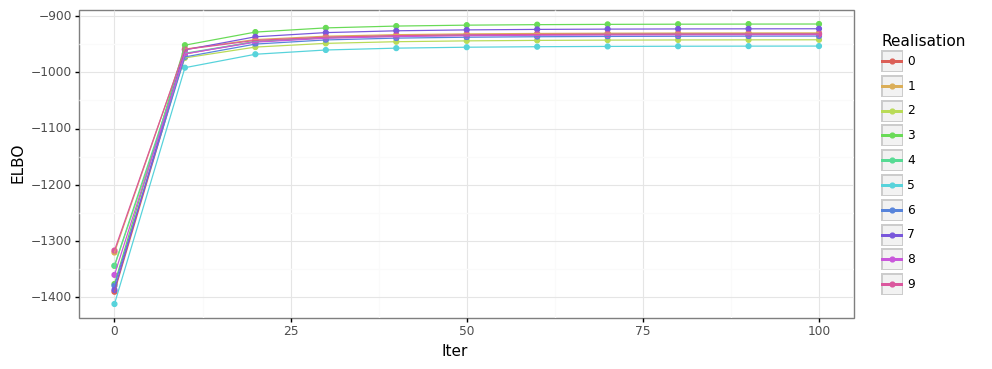

<ggplot: (8767676638714)>

In [15]:
diag_obj.plot_elbo_values()

Have all realisations of this model converged?

In [16]:
diag_obj.model.trace.groupby(["realisation"]).last()

,seed,iter,elbo,runtime,reached_convergence
realisation,,,,,
0,1324210,100,-931.276398,0.014966,False
1,1324340,100,-929.755887,0.014691,False
2,1324609,100,-942.023743,0.015506,False
3,1324752,100,-913.948664,0.015575,False
4,1324971,100,-931.992351,0.019445,False
5,1325121,100,-953.203946,0.017246,False
6,1325374,100,-935.434419,0.017820,False
7,1325701,100,-922.397428,0.015259,False
8,1325770,100,-932.845679,0.014858,False


**What are the distributions of reliability, $\theta$?**

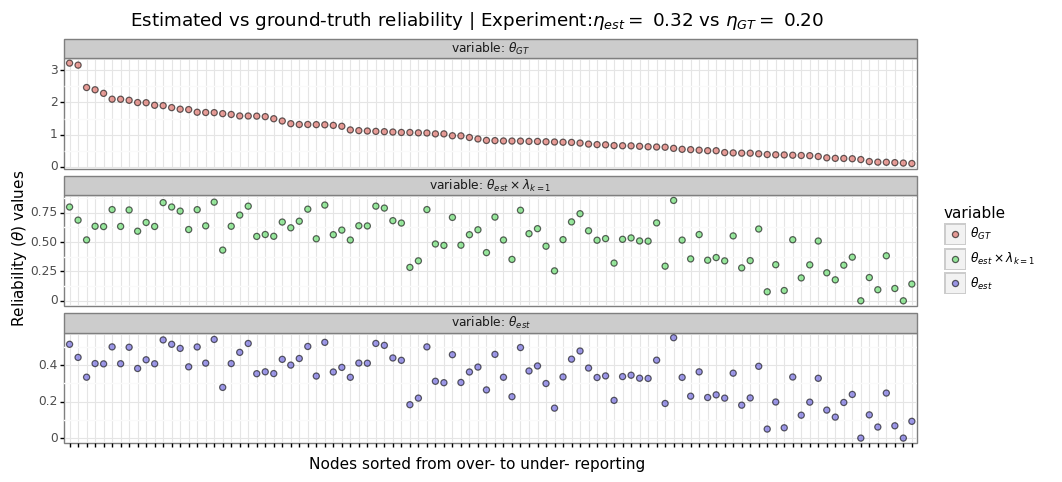

<ggplot: (8767676467228)>

In [17]:
g, node_order = diag_obj.plot_theta(theta_GT=experiment.network.theta, return_node_order=True)
# ggsave(g, filename="/mnt/data/example1_vimure_t_theta_distribution.png")
g

In [18]:
sp.stats.spearmanr(experiment.model.G_exp_theta_f.flatten(), experiment.network.theta.flatten())

SpearmanrResult(correlation=0.7012781278127811, pvalue=4.477377172275363e-16)

## Metrics

In [19]:
print("Reciprocity Ground Truth               = %.2f" % ground_truth_reciprocity(experiment, X=None))
print("Reciprocity X (union)                  = %.2f" % baseline_union_reciprocity(experiment, X=None))
print("Reciprocity X (intersection)           = %.2f" % baseline_intersection_reciprocity(experiment, X=None))

print()

print(r"Reciprocity ViMuRe(T) - Expected value = %.2f " % (metric_expected_reciprocity_posterior(experiment, X=None)))
print()


optimal_threshold = vm.utils.get_optimal_threshold(experiment.model)
print(r"Reciprocity ViMuRe(T)                  = %.2f (threshold on rho = %2f)" % (custom_reciprocity_scoring_fixed_threshold(experiment, optimal_threshold), optimal_threshold))
print(r"Reciprocity ViMuRe(T)                  = %.2f (threshold on rho = %2f)" % (custom_reciprocity_scoring_005(experiment, X=None), 0.05))
print(r"Reciprocity ViMuRe(T)                  = %.2f (threshold on rho = %2f)" % (custom_reciprocity_scoring_010(experiment, X=None), 0.10))
print(r"Reciprocity ViMuRe(T)                  = %.2f (threshold on rho = %2f)" % (custom_reciprocity_scoring_020(experiment, X=None), 0.20))
print(r"Reciprocity ViMuRe(T)                  = %.2f (threshold on rho = %2f)" % (custom_reciprocity_scoring_050(experiment, X=None), 0.50))

print()

print("Density Ground Truth     = %.5f" % ground_truth_net_density(experiment, X=None))
print("Density X (union)        = %.5f" % baseline_union_net_density(experiment, X=None))
print("Density X (intersection) = %.5f" % baseline_intersection_net_density(experiment, X=None))
print()
print(r"Density Expected(rho)    = %.5f" % get_network_density(experiment.model.rho[0,:,:,1]))
print()
print(r"Density ViMuRe(T)        = %.5f (same optimal threshold on rho as before = %.2f)" % (custom_net_density_scoring_fixed_threshold(experiment, optimal_threshold), optimal_threshold))
print(r"Density ViMuRe(T)        = %.5f (threshold on rho = %.2f)" % (custom_net_density_scoring_005(experiment, X=None), 0.05))
print(r"Density ViMuRe(T)        = %.5f (threshold on rho = %.2f)" % (custom_net_density_scoring_010(experiment, X=None), 0.10))
print(r"Density ViMuRe(T)        = %.5f (threshold on rho = %.2f)" % (custom_net_density_scoring_020(experiment, X=None), 0.20))
print(r"Density ViMuRe(T)        = %.5f (threshold on rho = %.2f)" % (custom_net_density_scoring_050(experiment, X=None), 0.50))

print()

print()

print("AUC on X = %.2f" % auc_on_X(experiment, X=None))
print("AUC on Y = %.2f" % auc_on_Y(experiment, X=None))

Reciprocity Ground Truth               = 0.20
Reciprocity X (union)                  = 0.51
Reciprocity X (intersection)           = 0.20

Reciprocity ViMuRe(T) - Expected value = 0.13 

Reciprocity ViMuRe(T)                  = 0.28 (threshold on rho = 0.162795)
Reciprocity ViMuRe(T)                  = 0.45 (threshold on rho = 0.050000)
Reciprocity ViMuRe(T)                  = 0.38 (threshold on rho = 0.100000)
Reciprocity ViMuRe(T)                  = 0.20 (threshold on rho = 0.200000)
Reciprocity ViMuRe(T)                  = 0.09 (threshold on rho = 0.500000)

Density Ground Truth     = 0.04758
Density X (union)        = 0.07949
Density X (intersection) = 0.02010

Density Expected(rho)    = 0.05594

Density ViMuRe(T)        = 0.06586 (same optimal threshold on rho as before = 0.16)
Density ViMuRe(T)        = 0.07596 (threshold on rho = 0.05)
Density ViMuRe(T)        = 0.07182 (threshold on rho = 0.10)
Density ViMuRe(T)        = 0.06202 (threshold on rho = 0.20)
Density ViMuRe(T)      

## ROC Curve (to ground truth Y)

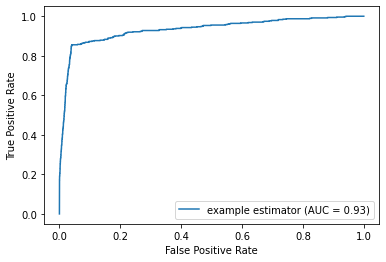

In [20]:
preds = experiment.decision_function()
fpr, tpr, thresholds = roc_curve(experiment.network.Y[0].flatten(), preds)
roc_auc = sklearn.metrics.auc(fpr, tpr)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = vm.utils.get_optimal_threshold(experiment.model)

sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator').plot()

# Initial simulation


## Parameters setup

In [21]:
parameters = {
    "reciprocity_Y" : [0.2], #np.arange(0.1, 0.9, 0.1),
    "planted_mutuality" : np.arange(0.1, 0.9, 0.1),
    "X_seed" : np.arange(5), # Increase it to get more variability of results
    "Y_seed" : np.arange(5), 
    "vimure_seed" : np.arange(1),
    "vimure_mutuality" : [False, True],
}

from sklearn.model_selection import ParameterGrid

print("These setup implicates in running %d simulations" % len(ParameterGrid(parameters)))

These setup implicates in running 400 simulations


## Scoring functions



In [24]:
grid_search_scoring = {
    "estimated_eta"             : estimated_eta,
    "AUC_on_Y"                  : auc_on_Y,
    "AUC_on_X"                  : auc_on_X,
    
    # Metrics for fixed thresholds of rho
    "F1_threshold_005"          :  custom_f1_scoring_005,
    "F1_threshold_010"          :  custom_f1_scoring_010,
    "F1_threshold_020"          :  custom_f1_scoring_020,
    "F1_threshold_050"          :  custom_f1_scoring_050,
    "reciprocity_threshold_005" :  custom_reciprocity_scoring_005,
    "reciprocity_threshold_010" :  custom_reciprocity_scoring_010,
    "reciprocity_threshold_020" :  custom_reciprocity_scoring_020,
    "reciprocity_threshold_050" :  custom_reciprocity_scoring_050,
    
    "density_threshold_005" :  custom_net_density_scoring_005,
    "density_threshold_010" :  custom_net_density_scoring_010,
    "density_threshold_020" :  custom_net_density_scoring_020,
    "density_threshold_050" :  custom_net_density_scoring_050,
    
    # Metrics calculated after applying the optimal threshold on rho
    "optimal_threshold"        :      find_optimal_threshold,
    "F1_threshold_optimal"     :      custom_f1_scoring_optimal_threshold,
    "reciprocity_threshold_optimal":  custom_reciprocity_scoring_optimal_threshold,
    "density_threshold_optimal":      custom_net_density_scoring_optimal_threshold,
    
    # Baseline metrics
    "reciprocity_ground_truth"  :  ground_truth_reciprocity,
    "reciprocity_union"         :  baseline_union_reciprocity,
    "reciprocity_intersection"  :  baseline_intersection_reciprocity,
    "reciprocity_expected_value":  metric_expected_reciprocity_posterior,
    
    "density_ground_truth":    ground_truth_net_density,
    "density_union"         :  baseline_union_net_density,
    "density_intersection"  :  baseline_intersection_net_density,
    "density_expected_value":  metric_expected_density_posterior
}

## Run experiment

In [25]:
clf = GridSearchCV(
        estimator=VaryingReciprocityExp(verbose=False),
        param_grid=parameters,
        cv=[(slice(None), slice(None))],
        scoring=grid_search_scoring,
        verbose=1,
        refit="AUC_on_X", # This indicate which metric GridSearchCV will use to select the best estimator
        n_jobs=8,  # How many parallel jobs to run, tune accordingly
        return_train_score=True,
    )


In [26]:
fake_X = sp.sparse.dok_matrix((1, 1))
clf.fit(fake_X, None)

Fitting 1 folds for each of 400 candidates, totalling 400 fits


GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=VaryingReciprocityExp(), n_jobs=8,
             param_grid={'X_seed': array([0, 1, 2, 3, 4]),
                         'Y_seed': array([0, 1, 2, 3, 4]),
                         'planted_mutuality': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                         'reciprocity_Y': [0.2],
                         'vimure_mutuality': [False, True],
                         'vimure_seed': array([0])},
             refit='AUC_on_X', return_train_scor...
                      'reciprocity_threshold_020': <function custom_reciprocity_scoring_020 at 0x7f95f82dc5e0>,
                      'reciprocity_threshold_050': <function custom_reciprocity_scoring_050 at 0x7f95f82dc8b0>,
                      'reciprocity_threshold_optimal': <function custom_reciprocity_scoring_optimal_threshold at 0x7f95f82dc940>,
                      'reciprocity_union': <function baseline_union_reciprocity at 0x7f95f8

## Obtain results

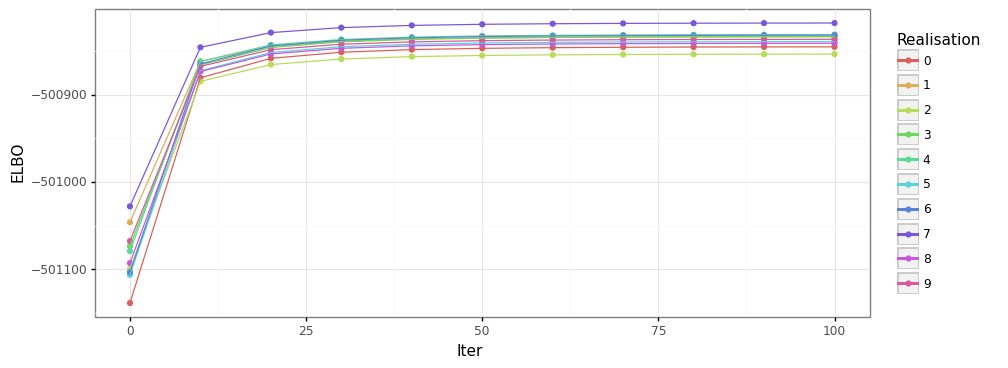

<ggplot: (8767675951851)>

In [27]:
vm.diagnostics.Diagnostics(clf.best_estimator_.model, clf.best_estimator_.network).plot_elbo_values()

In [28]:
results_df = pd.DataFrame(clf.cv_results_)

cols = results_df.columns
selected_cols = [col for col in cols if "mean_train_reciprocity" in col]
results_df[selected_cols].T

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
mean_train_reciprocity_threshold_005,0.333901,0.269504,0.455571,0.387334,0.559850,0.491481,0.583726,0.493719,0.651852,0.550857,...,0.633406,0.531616,0.683382,0.588795,0.696729,0.585907,0.777863,0.695796,0.799235,0.720055
mean_train_reciprocity_threshold_010,0.333901,0.225092,0.456215,0.336923,0.559850,0.403361,0.582742,0.425532,0.651852,0.492083,...,0.633406,0.467742,0.683382,0.519406,0.696729,0.496358,0.778462,0.631766,0.797703,0.638992
mean_train_reciprocity_threshold_020,0.333901,0.155378,0.456860,0.196522,0.559850,0.264848,0.581065,0.269767,0.651852,0.323782,...,0.633406,0.324675,0.683382,0.350614,0.696729,0.322785,0.776579,0.449339,0.796925,0.444648
mean_train_reciprocity_threshold_050,0.331058,0.061269,0.457507,0.096386,0.560549,0.135135,0.574316,0.107004,0.651113,0.123260,...,0.633188,0.117202,0.677579,0.165154,0.692239,0.106195,0.773643,0.166667,0.789406,0.165152
mean_train_reciprocity_threshold_optimal,1.000000,0.221811,1.000000,0.271545,1.000000,0.275040,1.000000,0.267496,1.000000,0.247649,...,1.000000,0.289355,1.000000,0.282544,1.000000,0.215714,1.000000,0.273639,1.000000,0.289663
mean_train_reciprocity_ground_truth,0.244635,0.244635,0.244635,0.244635,0.244635,0.244635,0.244635,0.244635,0.244635,0.244635,...,0.278884,0.278884,0.278884,0.278884,0.278884,0.278884,0.278884,0.278884,0.278884,0.278884
mean_train_reciprocity_union,0.333901,0.333901,0.455571,0.455571,0.559850,0.559850,0.583039,0.583039,0.651852,0.651852,...,0.634199,0.634199,0.683382,0.683382,0.696729,0.696729,0.777863,0.777863,0.800000,0.800000
mean_train_reciprocity_intersection,0.189189,0.189189,0.151899,0.151899,0.309524,0.309524,0.338308,0.338308,0.400000,0.400000,...,0.339286,0.339286,0.445230,0.445230,0.520376,0.520376,0.643392,0.643392,0.610169,0.610169
mean_train_reciprocity_expected_value,0.329556,0.085431,0.452497,0.121654,0.555124,0.167193,0.572219,0.157541,0.645548,0.168083,...,0.622255,0.184704,0.671451,0.214056,0.686059,0.180919,0.762589,0.237139,0.772403,0.246289


In [29]:
aux_df = \
    results_df.groupby(["param_reciprocity_Y", "param_planted_mutuality"])\
    .mean(selected_cols)[selected_cols]\
    .query("param_reciprocity_Y == 0.2")

aux_df


mean_train_reciprocity_threshold_005  \
param_reciprocity_Y param_planted_mutuality                                         
0.2                 0.1                                                  0.300472   
                    0.2                                                  0.410134   
                    0.3                                                  0.500397   
                    0.4                                                  0.565930   
                    0.5                                                  0.630336   
                    0.6                                                  0.665664   
                    0.7                                                  0.709919   
                    0.8                                                  0.743848   

                                             mean_train_reciprocity_threshold_010  \
param_reciprocity_Y param_planted_mutuality                                         
0.2                 0.1                                                  0.273526   
                    0.2                                                  0.377248   
                    0.3                                                  0.462799   
                    0.4                                                  0.525909   
                    0.5                                                  0.587293   
                    0.6                                                  0.621682   
                    0.7                                                  0.666320   
                    0.8                                                  0.699565   

                                             mean_train_reciprocity_threshold_020  \
param_reciprocity_Y param_planted_mutuality                                         
0.2                 0.1                                                  0.228925   
                    0.2                                                  0.315590   
                    0.3                                                  0.388485   
                    0.4                                                  0.443111   
                    0.5                                                  0.499441   
                    0.6                                                  0.532032   
                    0.7                                                  0.571944   
                    0.8                                                  0.606571   

                                             mean_train_reciprocity_threshold_050  \
param_reciprocity_Y param_planted_mutuality                                         
0.2                 0.1                                                  0.192556   
                    0.2                                                  0.260917   
                    0.3                                                  0.313494   
                    0.4                                                  0.352114   
                    0.5                                                  0.395609   
                    0.6                                                  0.412543   
                    0.7                                                  0.436915   
                    0.8                                                  0.462214   

                                             mean_train_reciprocity_threshold_optimal  \
param_reciprocity_Y param_planted_mutuality                                             
0.2                 0.1                                                      0.614319   
                    0.2                                                      0.628650   
                    0.3                                                      0.633885   
                    0.4                                                      0.626427   
                    0.5                                                      0.625699   
                  

## Plots

Reshape results DataFrame to a format we can visualize:

In [125]:
group_cols = [
              "param_reciprocity_Y", 
              "param_planted_mutuality",
              "param_vimure_mutuality"   ]

main_metric = "reciprocity" # Options: "AUC", "F1" and "reciprocity" 

metrics = [col for col in results_df.columns if ("mean_train" in col) and ((main_metric in col))]

# All the relevant columns we want to use in our plots
all_cols = group_cols + metrics

Which metrics we will plot?

In [32]:
all_cols

['param_X_seed',
 'param_Y_seed',
 'param_reciprocity_Y',
 'param_planted_mutuality',
 'param_vimure_mutuality',
 'mean_train_density_threshold_005',
 'mean_train_density_threshold_010',
 'mean_train_density_threshold_020',
 'mean_train_density_threshold_050',
 'mean_train_density_threshold_optimal',
 'mean_train_density_ground_truth',
 'mean_train_density_union',
 'mean_train_density_intersection',
 'mean_train_density_expected_value']

**Rename scikit-learn default columns names** to more useful names for our purposes:

In [113]:
columns_map = {"param_reciprocity_Y"                      : "reciprocity_Y",
               "param_planted_mutuality"                  : "mutuality_X",
               "param_vimure_mutuality"                   : "model",
               
               "mean_train_AUC_on_Y"                      : r"AUC (on Y)",
               "mean_train_AUC_on_X"                      : r"AUC (on X)",
               
               "mean_train_F1_threshold_005"              : r"F1 ($\rho_{t=0.05}$)",
               "mean_train_F1_threshold_010"              : r"F1 ($\rho_{t=0.10}$)",
               "mean_train_F1_threshold_020"              : r"F1 ($\rho_{t=0.20}$)",
               "mean_train_F1_threshold_050"              : r"F1 ($\rho_{t=0.50}$)",
               "mean_train_F1_threshold_optimal"          : r"F1 ($\rho_{t=t*  }$)",
               
               "mean_train_reciprocity_ground_truth"      : "ground truth",
               "mean_train_reciprocity_union"             : "union",
               "mean_train_reciprocity_intersection"      : "intersection",
               "mean_train_reciprocity_expected_value"    : r"(expected value)",
               "mean_train_reciprocity_threshold_005"     : r"($\rho_{t=0.05}$)",
               "mean_train_reciprocity_threshold_010"     : r"($\rho_{t=0.10}$)",
               "mean_train_reciprocity_threshold_020"     : r"($\rho_{t=0.20}$)",
               "mean_train_reciprocity_threshold_050"     : r"($\rho_{t=0.50}$)",
               "mean_train_reciprocity_threshold_optimal" : r"($\rho_{t=t*  }$)",
              
               "mean_train_density_ground_truth"      : "ground truth",
               "mean_train_density_union"             : "union",
               "mean_train_density_intersection"      : "intersection",
               "mean_train_density_expected_value"    : r"(expected value)",
               "mean_train_density_threshold_005"     : r"($\rho_{t=0.05}$)",
               "mean_train_density_threshold_010"     : r"($\rho_{t=0.10}$)",
               "mean_train_density_threshold_020"     : r"($\rho_{t=0.20}$)",
               "mean_train_density_threshold_050"     : r"($\rho_{t=0.50}$)",
               "mean_train_density_threshold_optimal" : r"($\rho_{t=t*  }$)"}



**Prepare DataFrame** for our plots:

In [103]:
plot_df = results_df[all_cols].copy()
plot_df["param_planted_mutuality"] = plot_df["param_planted_mutuality"].apply(lambda x: np.round(x, 2)).astype(str)
plot_df["param_reciprocity_Y"] = plot_df["param_reciprocity_Y"].apply(lambda x: np.round(x, 2)).astype(str)
plot_df["param_vimure_mutuality"] = \
    plot_df["param_vimure_mutuality"].apply(lambda x: r"$ViMuRe_{T}$" if x else r"$ViMuRe_{F}$")

main_metric = "density"

plot_df = plot_df.rename(columns=columns_map)
# plot_df = pd.melt(plot_df, id_vars=[columns_map[col] for col in group_cols])

plot_df.head()

,reciprocity_Y,mutuality_X,model,($\rho_{t=0.05}$),($\rho_{t=0.10}$),($\rho_{t=0.20}$),($\rho_{t=0.50}$),($\rho_{t=0.54\eta_{est} - 0.1}$),ground truth,union,intersection,(expected value)
0,0.2,0.1,$ViMuRe_{F}$,0.059293,0.059293,0.059293,0.059192,1.000000,0.047071,0.059293,0.014949,0.058795
1,0.2,0.1,$ViMuRe_{T}$,0.056970,0.054747,0.050707,0.046162,0.054646,0.047071,0.059293,0.014949,0.047494
2,0.2,0.2,$ViMuRe_{F}$,0.071515,0.071414,0.071313,0.071212,1.000000,0.047071,0.071515,0.015960,0.070520
3,0.2,0.2,$ViMuRe_{T}$,0.068485,0.065556,0.057980,0.050303,0.062020,0.047071,0.071515,0.015960,0.052396
4,0.2,0.3,$ViMuRe_{F}$,0.080707,0.080707,0.080707,0.080606,1.000000,0.047071,0.080707,0.016970,0.079843


In [127]:
plot_df = results_df[all_cols].copy()
plot_df["param_planted_mutuality"] = plot_df["param_planted_mutuality"].apply(lambda x: np.round(x, 2)).astype(str)
plot_df["param_reciprocity_Y"] = plot_df["param_reciprocity_Y"].apply(lambda x: np.round(x, 2)).astype(str)
plot_df["param_vimure_mutuality"] = \
    plot_df["param_vimure_mutuality"].apply(lambda x: r"$ViMuRe_{T}$" if x else r"$ViMuRe_{F}$")

main_metric = "reciprocity"

plot_df = plot_df.rename(columns=columns_map)
plot_df = pd.melt(plot_df, id_vars=[columns_map[col] for col in group_cols])

def group_decider(row):
    if row["variable"] in ["ground truth", "union", "intersection"]:
        return row["variable"]
    elif row["model"] == r"$ViMuRe_{F}$":
        return row["model"]
    else:
        return row["model"] + " " + row["variable"]
    
def color_group_decider(row):
    if row["variable"] in ["ground truth", "union", "intersection"]:
        return row["variable"]
    else:
        return row["model"]
    
X_group_categories = ["ground truth", "intersection", "union"]
    
if main_metric == "AUC":
    X_group_categories = X_group_categories + [ r"$ViMuRe_{F}$" + " | " + r"AUC (on Y)",
                                                r"$ViMuRe_{F}$" + " | " + r"AUC (on X)",
                                                r"$ViMuRe_{T}$" + " | " + r"AUC (on Y)",
                                                r"$ViMuRe_{T}$" + " | " + r"AUC (on X)"]
elif main_metric == "F1":
    X_group_categories = X_group_categories + [ r"$ViMuRe_{F}$" + " | " + r"AUC (on Y)",
                                                r"$ViMuRe_{F}$" + " | " + r"AUC (on X)",
                                                r"$ViMuRe_{T}$" + " | " + r"AUC (on Y)",
                                                r"$ViMuRe_{T}$" + " | " + r"AUC (on X)"]
elif main_metric == "reciprocity" or main_metric == "density":
    X_group_categories = X_group_categories + [r"$ViMuRe_{F}$",
                                               r"$ViMuRe_{T}$" + " " + r"(expected value)", 
                                               r"$ViMuRe_{T}$" + " " + r"($\rho_{t=t*  }$)", 
                                               r"$ViMuRe_{T}$" + " " + r"($\rho_{t=0.05}$)",
                                               r"$ViMuRe_{T}$" + " " + r"($\rho_{t=0.10}$)",
                                               r"$ViMuRe_{T}$" + " " + r"($\rho_{t=0.20}$)",
                                               r"$ViMuRe_{T}$" + " " + r"($\rho_{t=0.50}$)"]

plot_df["X_group"] = pd.Categorical(plot_df.apply(group_decider, axis=1), categories=X_group_categories)

plot_df["color_group"] = pd.Categorical(plot_df.apply(color_group_decider, axis=1), 
                                        categories=["ground truth", "intersection", "union", r"$ViMuRe_{F}$", r"$ViMuRe_{T}$"])

In [122]:
plot_df["variable"].value_counts()

($\rho_{t=0.05}$)    400
($\rho_{t=0.10}$)    400
($\rho_{t=0.20}$)    400
($\rho_{t=0.50}$)    400
($\rho_{t=t*  }$)    400
ground truth         400
union                400
intersection         400
(expected value)     400
Name: variable, dtype: int64

**The actual plot:**

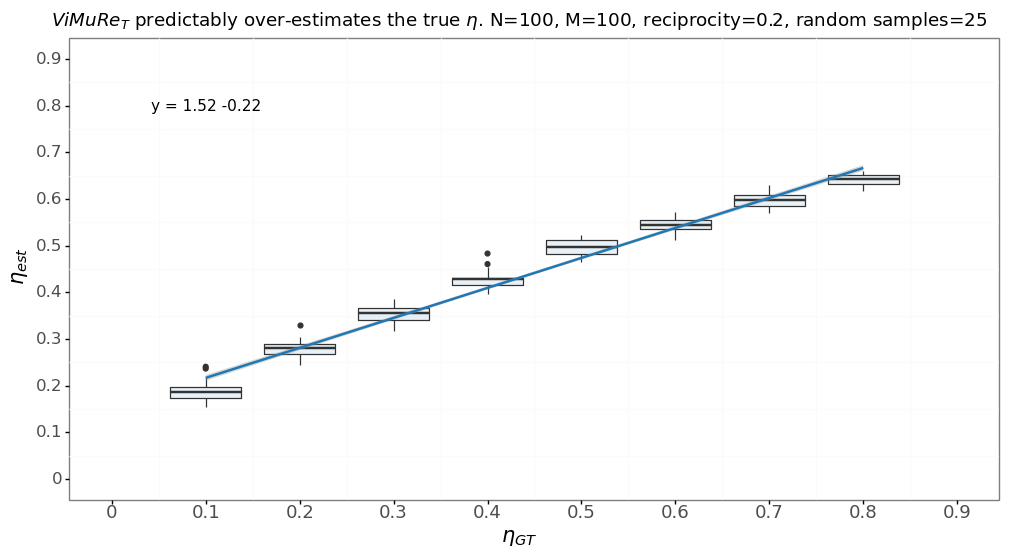

<ggplot: (8767676297391)>

In [106]:
test_df = results_df[results_df["param_vimure_mutuality"] == True].copy()
test_df.groupby(["param_vimure_mutuality", "param_planted_mutuality"])

test_df = test_df[["param_planted_mutuality", "mean_train_optimal_threshold", "mean_train_estimated_eta"]]
test_df["mean_train_optimal_threshold"] = test_df["mean_train_optimal_threshold"].astype(float)
test_df["param_planted_mutuality"] = test_df["param_planted_mutuality"].astype(float)

# Fit 1D polynomial
linefit = np.polyfit(test_df["mean_train_estimated_eta"], test_df["param_planted_mutuality"], 1)


g = (ggplot(test_df, aes(x="param_planted_mutuality", group="param_planted_mutuality")) +
     geom_boxplot(aes(y="mean_train_estimated_eta"), fill="tab:blue", alpha=0.1) +
     geom_smooth(aes(y="mean_train_estimated_eta", group=1), method="lm", color="tab:blue") +
     scale_x_continuous(name=r"$\eta_{GT}$", limits=(0, 0.9), breaks=np.arange(0, 1, 0.1)) +
     scale_y_continuous(name=r"$\eta_{est}$", limits=(0, 0.9), breaks=np.arange(0, 1, 0.1)) +
     annotate(geom="text", x=0.1, y=0.8, label=r"y = %.2f %+.2f"  % (linefit[0], linefit[1]) ) + 
     theme_bw() + 
     theme(figure_size=(12, 6),
           axis_text_x=element_text(rotation=0, margin={'b': 30, 'r': 5}, size=13),
           axis_text_y=element_text(size=12),
           panel_grid_major=element_blank(),
           strip_background = element_blank(),
           strip_text_x = element_blank(),
           axis_title_x=element_text(size=15),
           axis_title_y=element_text(size=15),
           legend_position = (9, 0.6),
           legend_background = element_rect(fill = "white", colour = None),
           legend_direction="vertical") + 
    ggtitle(r"$ViMuRe_{T}$ predictably over-estimates the true $\eta$. N=100, M=100, reciprocity=0.2, random samples=25"))

# ggsave(g, filename="/mnt/data/true_vs_est_eta_reciprocity_0_2.png")

g

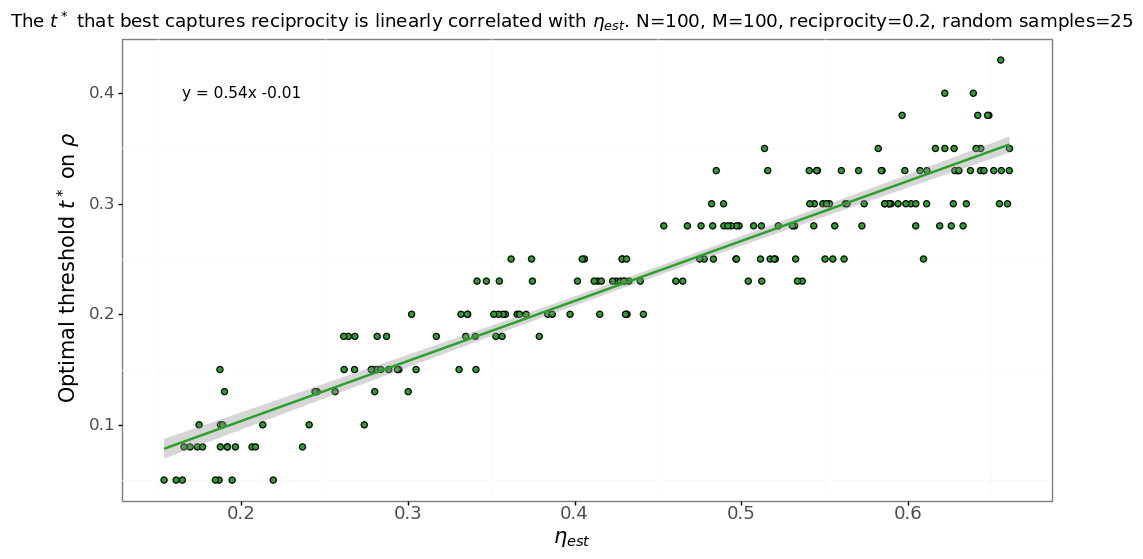

<ggplot: (8767676262349)>

In [107]:
test_df = results_df[results_df["param_vimure_mutuality"] == True].copy()
test_df.groupby(["param_vimure_mutuality", "param_planted_mutuality"])

test_df = test_df[["param_planted_mutuality", "mean_train_optimal_threshold", "mean_train_estimated_eta"]]
test_df["mean_train_optimal_threshold"] = test_df["mean_train_optimal_threshold"].astype(float)
test_df["param_planted_mutuality"] = test_df["param_planted_mutuality"].astype(float)

linefit = np.polyfit(test_df["mean_train_estimated_eta"], test_df["mean_train_optimal_threshold"], 1)


g = (ggplot(test_df, aes(x="mean_train_estimated_eta", group="mean_train_estimated_eta")) +
     geom_point(aes(y="mean_train_optimal_threshold"), fill="tab:green", size=2) +
     geom_smooth(aes(y="mean_train_optimal_threshold", group=1), method="lm", color="tab:green") +
     scale_x_continuous(name=r"$\eta_{est}$") +
     scale_y_continuous(name=r"Optimal threshold $t^*$ on $\rho$") +
     annotate(geom="text", x=0.2, y=0.4, label=r"y = %.2fx %+.2f"  % (linefit[0], linefit[1]) ) + 
     theme_bw() + 
     theme(figure_size=(12, 6),
           axis_text_x=element_text(rotation=0, margin={'b': 30, 'r': 5}, size=13),
           axis_text_y=element_text(size=12),
           panel_grid_major=element_blank(),
           strip_background = element_blank(),
           strip_text_x = element_blank(),
           axis_title_x=element_text(size=15),
           axis_title_y=element_text(size=15),
           legend_position = (9, 0.6),
           legend_background = element_rect(fill = "white", colour = None),
           legend_direction="vertical") + 
    ggtitle(r"The $t^*$ that best captures reciprocity is linearly correlated with $\eta_{est}$. N=100, M=100, reciprocity=0.2, random samples=25"))

# ggsave(g, filename="/mnt/data/threshold_vs_est_eta_reciprocity_0_2.pdf")

g

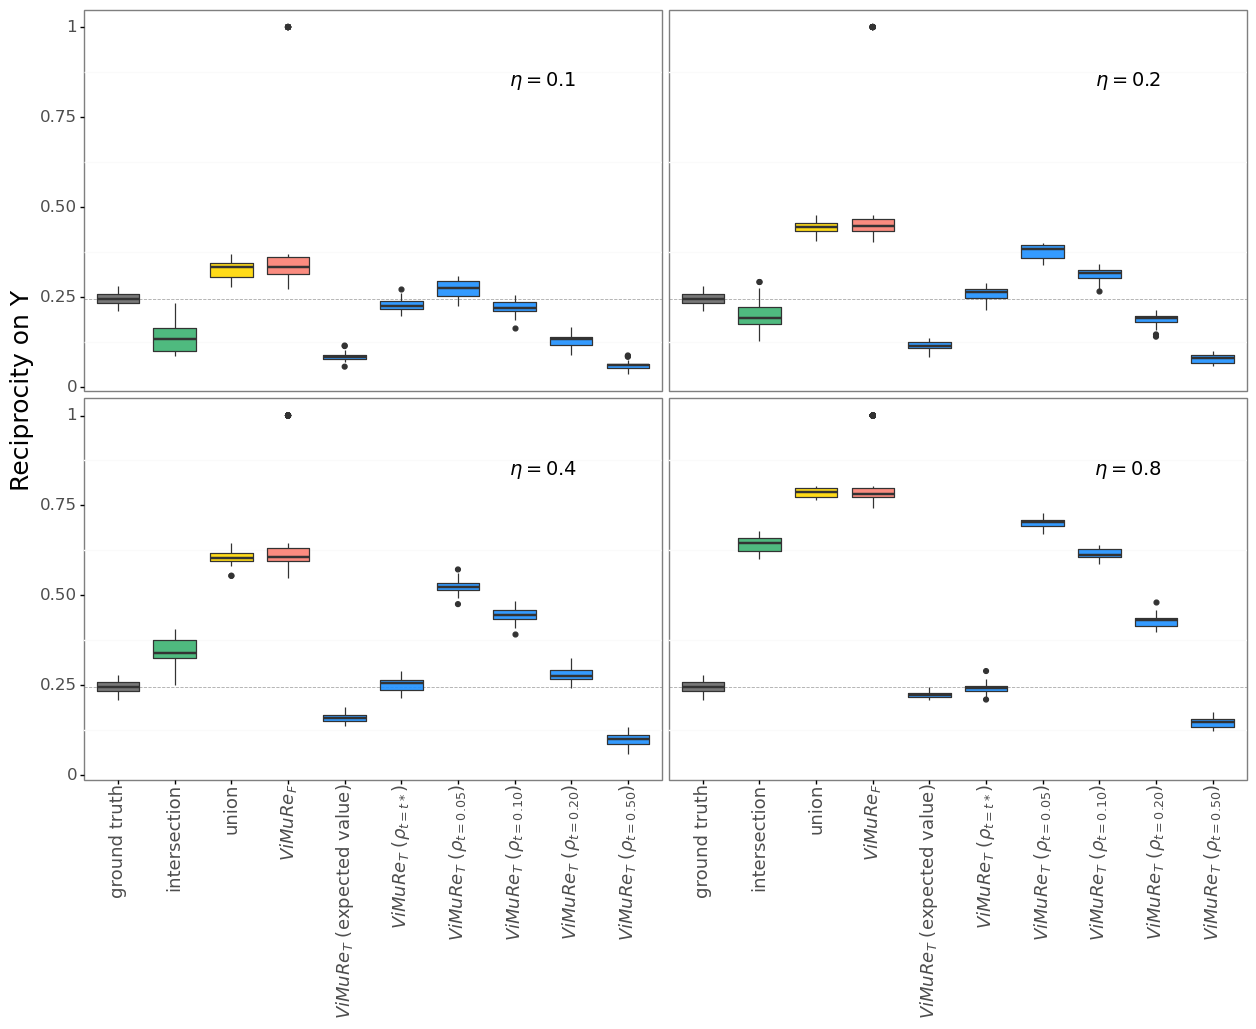

<ggplot: (8767593483930)>

In [130]:
selected_reciprocities = ["0.1", "0.2", "0.4", "0.8"]

# selected_y_reciprocity = '0.4'

aux_df = pd.concat([plot_df.query("reciprocity_Y == '0.2' & mutuality_X == '%s'" % (selected_y_reciprocity)) 
                           for selected_y_reciprocity in selected_reciprocities])
# aux_df = aux_df[aux_df["X_group"] != r"$ViMuRe_{F}$"]

annotation_df = aux_df.groupby(["mutuality_X"])[["value"]].max().reset_index()
annotation_df["value"] = 0.85
annotation_df["X_group"] = 8.5
annotation_df["color_group"] = None
annotation_df["eta_annotation"] = annotation_df["mutuality_X"].apply(lambda x: r"$\eta = %s$" % x) 

# Ground truth average line
gt_line_df = aux_df[aux_df["variable"] == "ground truth"].groupby(["reciprocity_Y", "mutuality_X", "variable"])[["value"]].mean().reset_index()


g = (ggplot(aux_df, 
            aes(x="X_group", 
                y="value",
                fill="color_group")) +
     geom_hline(aes(yintercept="value"), data=gt_line_df, linetype="dashed", color="tab:gray", size=0.35, alpha=0.65) +
     geom_boxplot(position="dodge", alpha=0.9) + 
     scale_fill_manual(name="Model Type",
                       values={"ground truth": "dimgrey",
                               "union": "gold",
                               "intersection": "mediumseagreen",
                               r"$ViMuRe_{F}$": "salmon",
                               r"$ViMuRe_{T}$": "dodgerblue"},
                      guide=False) +
     theme_bw() + 
     theme(figure_size=(15, 10),
           axis_text_x=element_text(rotation=90, margin={'b': 30, 'r': 5}, size=13),
           axis_text_y=element_text(size=12),
           panel_grid_major=element_blank(),
           strip_background = element_blank(),
           strip_text_x = element_blank(),
           axis_title_y=element_text(size=18),
           legend_position = (9, 0.6),
           legend_background = element_rect(fill = "white", colour = None),
           legend_direction="vertical") +
     geom_text(aes(label="eta_annotation"), data=annotation_df, size=14, color="black") +
     scale_x_discrete(name="", breaks=X_group_categories) +
     scale_y_continuous(name="Reciprocity on Y") +
     facet_wrap(" ~ mutuality_X", labeller=None, ncol=2) #+ 
#      ggtitle("Comparison of reciprocity")
    )

save_filename = "/mnt/data/metric_%s_fixed_reciprocity_Y.pdf" % (main_metric)

# ggsave(g, filename=save_filename, dpi=300)

g

# Alternative Simulation: fix the optimal threshold

Here, we will re-do the experiment above. This time, however, I am using the heuristic line equation we found. 

$$t^* = 0.54 \eta_{est} - 0.01$$


## Parameter Setup

In [68]:
parameters = {
    "reciprocity_Y" : [0.2], #np.arange(0.1, 0.9, 0.1),
    "planted_mutuality" : np.arange(0.1, 0.9, 0.1),
    "X_seed" : np.arange(5), # Increase it to get more variability of results
    "Y_seed" : np.arange(5), 
    "vimure_seed" : np.arange(1),
    "vimure_mutuality" : [False, True],
}

from sklearn.model_selection import ParameterGrid

print("These setup implicates in running %d simulations" % len(ParameterGrid(parameters)))

These setup implicates in running 400 simulations


## Update scoring functions

In [67]:
def find_optimal_threshold(estimator, X=None):
    return 0.54 * estimator.model.G_exp_nu - 0.01


grid_search_scoring = {
    "estimated_eta"             : estimated_eta,
    "AUC_on_Y"                  : auc_on_Y,
    "AUC_on_X"                  : auc_on_X,
    
    # Metrics for fixed thresholds of rho
    "F1_threshold_005"          :  custom_f1_scoring_005,
    "F1_threshold_010"          :  custom_f1_scoring_010,
    "F1_threshold_020"          :  custom_f1_scoring_020,
    "F1_threshold_050"          :  custom_f1_scoring_050,
    "reciprocity_threshold_005" :  custom_reciprocity_scoring_005,
    "reciprocity_threshold_010" :  custom_reciprocity_scoring_010,
    "reciprocity_threshold_020" :  custom_reciprocity_scoring_020,
    "reciprocity_threshold_050" :  custom_reciprocity_scoring_050,
    
    "density_threshold_005" :  custom_net_density_scoring_005,
    "density_threshold_010" :  custom_net_density_scoring_010,
    "density_threshold_020" :  custom_net_density_scoring_020,
    "density_threshold_050" :  custom_net_density_scoring_050,
    
    # Metrics calculated after applying the optimal threshold on rho
    "optimal_threshold"        :      find_optimal_threshold,
    "F1_threshold_optimal"     :      custom_f1_scoring_optimal_threshold,
    "reciprocity_threshold_optimal":  custom_reciprocity_scoring_optimal_threshold,
    "density_threshold_optimal":      custom_net_density_scoring_optimal_threshold,
    
    # Baseline metrics
    "reciprocity_ground_truth"  :  ground_truth_reciprocity,
    "reciprocity_union"         :  baseline_union_reciprocity,
    "reciprocity_intersection"  :  baseline_intersection_reciprocity,
    "reciprocity_expected_value":  metric_expected_reciprocity_posterior,
    
    "density_ground_truth":    ground_truth_net_density,
    "density_union"         :  baseline_union_net_density,
    "density_intersection"  :  baseline_intersection_net_density,
    "density_expected_value":  metric_expected_density_posterior
}

## Run experiment

In [69]:
clf = GridSearchCV(
        estimator=VaryingReciprocityExp(verbose=False),
        param_grid=parameters,
        cv=[(slice(None), slice(None))],
        scoring=grid_search_scoring,
        verbose=1,
        refit="AUC_on_X", # This indicate which metric GridSearchCV will use to select the best estimator
        n_jobs=8,  # How many parallel jobs to run, tune accordingly
        return_train_score=True,
    )

fake_X = sp.sparse.dok_matrix((1, 1))
clf.fit(fake_X, None)

Fitting 1 folds for each of 400 candidates, totalling 400 fits


GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=VaryingReciprocityExp(), n_jobs=8,
             param_grid={'X_seed': array([0, 1, 2, 3, 4]),
                         'Y_seed': array([0, 1, 2, 3, 4]),
                         'planted_mutuality': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                         'reciprocity_Y': [0.2],
                         'vimure_mutuality': [False, True],
                         'vimure_seed': array([0])},
             refit='AUC_on_X', return_train_scor...
                      'reciprocity_threshold_020': <function custom_reciprocity_scoring_020 at 0x7f95f82dc5e0>,
                      'reciprocity_threshold_050': <function custom_reciprocity_scoring_050 at 0x7f95f82dc8b0>,
                      'reciprocity_threshold_optimal': <function custom_reciprocity_scoring_optimal_threshold at 0x7f95f82dc940>,
                      'reciprocity_union': <function baseline_union_reciprocity at 0x7f95f8

## Results

In [132]:
results2_df = pd.DataFrame(clf.cv_results_)

cols = results2_df.columns
selected_cols = [col for col in cols if "mean_train_reciprocity" in col]

group_cols = ["param_reciprocity_Y", 
              "param_planted_mutuality",
              "param_vimure_mutuality"   ]

main_metric = "reciprocity" # Options: "AUC", "F1" and "reciprocity" 

metrics = [col for col in results2_df.columns if ("mean_train" in col) and ((main_metric in col))]

# All the relevant columns we want to use in our plots
all_cols = group_cols + metrics

In [138]:
columns_map = {"param_reciprocity_Y"                      : "reciprocity_Y",
               "param_planted_mutuality"                  : "mutuality_X",
               "param_vimure_mutuality"                   : "model",
               
               "mean_train_AUC_on_Y"                      : r"AUC (on Y)",
               "mean_train_AUC_on_X"                      : r"AUC (on X)",
               
               "mean_train_F1_threshold_005"              : r"F1 ($\rho_{t=0.05}$)",
               "mean_train_F1_threshold_010"              : r"F1 ($\rho_{t=0.10}$)",
               "mean_train_F1_threshold_020"              : r"F1 ($\rho_{t=0.20}$)",
               "mean_train_F1_threshold_050"              : r"F1 ($\rho_{t=0.50}$)",
               "mean_train_F1_threshold_optimal"          : r"F1 ($\rho_{t=t*  }$)",
               
               "mean_train_reciprocity_ground_truth"      : "ground truth",
               "mean_train_reciprocity_union"             : "union",
               "mean_train_reciprocity_intersection"      : "intersection",
               "mean_train_reciprocity_expected_value"    : r"(expected value)",
               "mean_train_reciprocity_threshold_005"     : r"($\rho_{t=0.05}$)",
               "mean_train_reciprocity_threshold_010"     : r"($\rho_{t=0.10}$)",
               "mean_train_reciprocity_threshold_020"     : r"($\rho_{t=0.20}$)",
               "mean_train_reciprocity_threshold_050"     : r"($\rho_{t=0.50}$)",
               "mean_train_reciprocity_threshold_optimal" : r"($\rho_{t=0.54\eta_{est} - 0.1}$)",
              
               "mean_train_density_ground_truth"      : "ground truth",
               "mean_train_density_union"             : "union",
               "mean_train_density_intersection"      : "intersection",
               "mean_train_density_expected_value"    : r"(expected value)",
               "mean_train_density_threshold_005"     : r"($\rho_{t=0.05}$)",
               "mean_train_density_threshold_010"     : r"($\rho_{t=0.10}$)",
               "mean_train_density_threshold_020"     : r"($\rho_{t=0.20}$)",
               "mean_train_density_threshold_050"     : r"($\rho_{t=0.50}$)",
               "mean_train_density_threshold_optimal" : r"($\rho_{t=0.54\eta_{est} - 0.1}$)"}

In [139]:
plot_df = results2_df[all_cols].copy()
plot_df["param_planted_mutuality"] = plot_df["param_planted_mutuality"].apply(lambda x: np.round(x, 2)).astype(str)
plot_df["param_reciprocity_Y"] = plot_df["param_reciprocity_Y"].apply(lambda x: np.round(x, 2)).astype(str)
plot_df["param_vimure_mutuality"] = \
    plot_df["param_vimure_mutuality"].apply(lambda x: r"$ViMuRe_{T}$" if x else r"$ViMuRe_{F}$")

plot_df = plot_df.rename(columns=columns_map)
plot_df = pd.melt(plot_df, id_vars=[columns_map[col] for col in group_cols])

def group_decider(row):
    if row["variable"] in ["ground truth", "union", "intersection"]:
        return row["variable"]
    elif row["model"] == r"$ViMuRe_{F}$":
        return row["model"]
    else:
        return row["model"] + " " + row["variable"]
    
def color_group_decider(row):
    if row["variable"] in ["ground truth", "union", "intersection"]:
        return row["variable"]
    else:
        return row["model"]
    
X_group_categories = ["ground truth", "intersection", "union"]
    
if main_metric == "AUC":
    X_group_categories = X_group_categories + [ r"$ViMuRe_{F}$" + " | " + r"AUC (on Y)",
                                                r"$ViMuRe_{F}$" + " | " + r"AUC (on X)",
                                                r"$ViMuRe_{T}$" + " | " + r"AUC (on Y)",
                                                r"$ViMuRe_{T}$" + " | " + r"AUC (on X)"]
elif main_metric == "F1":
    X_group_categories = X_group_categories + [ r"$ViMuRe_{F}$" + " | " + r"AUC (on Y)",
                                                r"$ViMuRe_{F}$" + " | " + r"AUC (on X)",
                                                r"$ViMuRe_{T}$" + " | " + r"AUC (on Y)",
                                                r"$ViMuRe_{T}$" + " | " + r"AUC (on X)"]
elif main_metric == "reciprocity" or main_metric == "density":
    X_group_categories = X_group_categories + [r"$ViMuRe_{F}$",
                                               r"$ViMuRe_{T}$" + " " + r"(expected value)", 
                                               r"$ViMuRe_{T}$" + " " + r"($\rho_{t=0.54\eta_{est} - 0.1}$)", 
                                               r"$ViMuRe_{T}$" + " " + r"($\rho_{t=0.05}$)",
                                               r"$ViMuRe_{T}$" + " " + r"($\rho_{t=0.10}$)",
                                               r"$ViMuRe_{T}$" + " " + r"($\rho_{t=0.20}$)",
                                               r"$ViMuRe_{T}$" + " " + r"($\rho_{t=0.50}$)"]

plot_df["X_group"] = pd.Categorical(plot_df.apply(group_decider, axis=1), categories=X_group_categories)

plot_df["color_group"] = pd.Categorical(plot_df.apply(color_group_decider, axis=1), 
                                        categories=["ground truth", "intersection", "union", r"$ViMuRe_{F}$", r"$ViMuRe_{T}$"])

In [136]:
plot_df["X_group"].value_counts()

$ViMuRe_{F}$                                      1200
ground truth                                       400
intersection                                       400
union                                              400
$ViMuRe_{T}$ (expected value)                      200
$ViMuRe_{T}$ ($\rho_{t=0.05}$)                     200
$ViMuRe_{T}$ ($\rho_{t=0.10}$)                     200
$ViMuRe_{T}$ ($\rho_{t=0.20}$)                     200
$ViMuRe_{T}$ ($\rho_{t=0.50}$)                     200
$ViMuRe_{T}$ ($\rho_{t=0.54\eta_{est} - 0.1}$)       0
Name: X_group, dtype: int64

**RECIPROCITY**

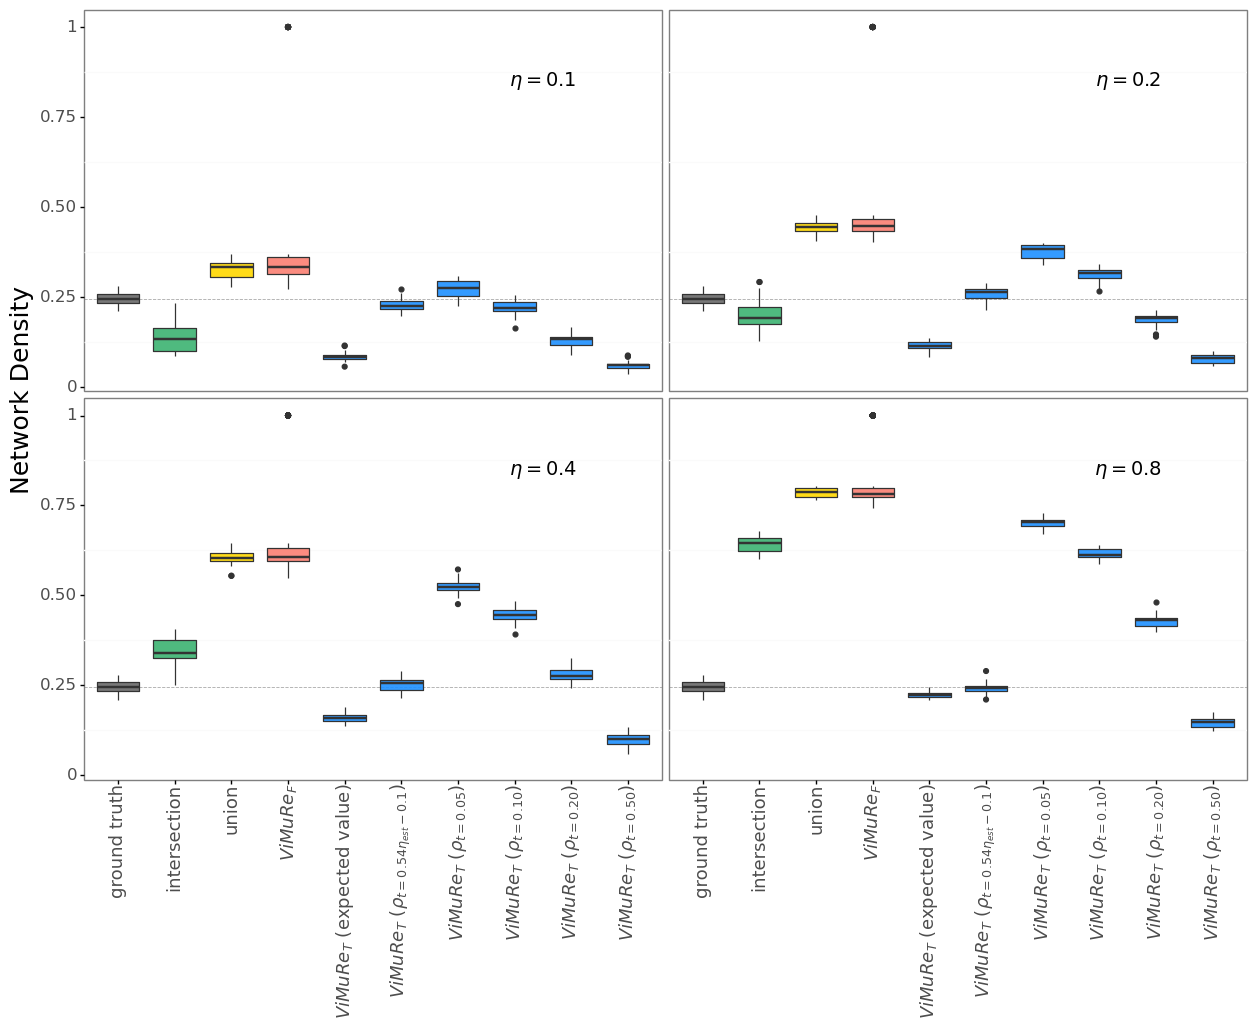

<ggplot: (8767593462775)>

In [141]:
selected_reciprocities = ["0.1", "0.2", "0.4", "0.8"]

# selected_y_reciprocity = '0.4'

aux_df = pd.concat([plot_df.query("reciprocity_Y == '0.2' & mutuality_X == '%s'" % (selected_y_reciprocity)) 
                           for selected_y_reciprocity in selected_reciprocities])
# aux_df = aux_df[aux_df["X_group"] != r"$ViMuRe_{F}$"]

annotation_df = aux_df.groupby(["mutuality_X"])[["value"]].max().reset_index()
annotation_df["value"] = 0.85
annotation_df["X_group"] = 8.5
annotation_df["color_group"] = None
annotation_df["eta_annotation"] = annotation_df["mutuality_X"].apply(lambda x: r"$\eta = %s$" % x) 

# Ground truth average line
gt_line_df = aux_df[aux_df["variable"] == "ground truth"].groupby(["reciprocity_Y", "mutuality_X", "variable"])[["value"]].mean().reset_index()


g = (ggplot(aux_df, 
            aes(x="X_group", 
                y="value",
                fill="color_group")) +
     geom_hline(aes(yintercept="value"), data=gt_line_df, linetype="dashed", color="tab:gray", size=0.35, alpha=0.65) +
     geom_boxplot(position="dodge", alpha=0.9) + 
     scale_fill_manual(name="Model Type",
                       values={"ground truth": "dimgrey",
                               "union": "gold",
                               "intersection": "mediumseagreen",
                               r"$ViMuRe_{F}$": "salmon",
                               r"$ViMuRe_{T}$": "dodgerblue"},
                      guide=False) +
     theme_bw() + 
     theme(figure_size=(15, 10),
           axis_text_x=element_text(rotation=90, margin={'b': 30, 'r': 5}, size=13),
           axis_text_y=element_text(size=12),
           panel_grid_major=element_blank(),
           strip_background = element_blank(),
           strip_text_x = element_blank(),
           axis_title_y=element_text(size=18),
           legend_position = (9, 0.6),
           legend_background = element_rect(fill = "white", colour = None),
           legend_direction="vertical") +
     geom_text(aes(label="eta_annotation"), data=annotation_df, size=14, color="black") +
     scale_x_discrete(name="", breaks=X_group_categories) +
     scale_y_continuous(name="Network Density") +
     facet_wrap(" ~ mutuality_X", labeller=None, ncol=2) #+ 
#      ggtitle("Comparison of network density")
    )

save_filename = "/mnt/data/metric_%s_fixed_reciprocity_Y.pdf" % (main_metric)

# ggsave(g, filename=save_filename, dpi=300)

g

**NETWORK DENSITY**

Obs: the code below is redudant and repetitive. Consider creating a function to replicate it in the future.

/opt/conda/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 100 rows containing non-finite values.


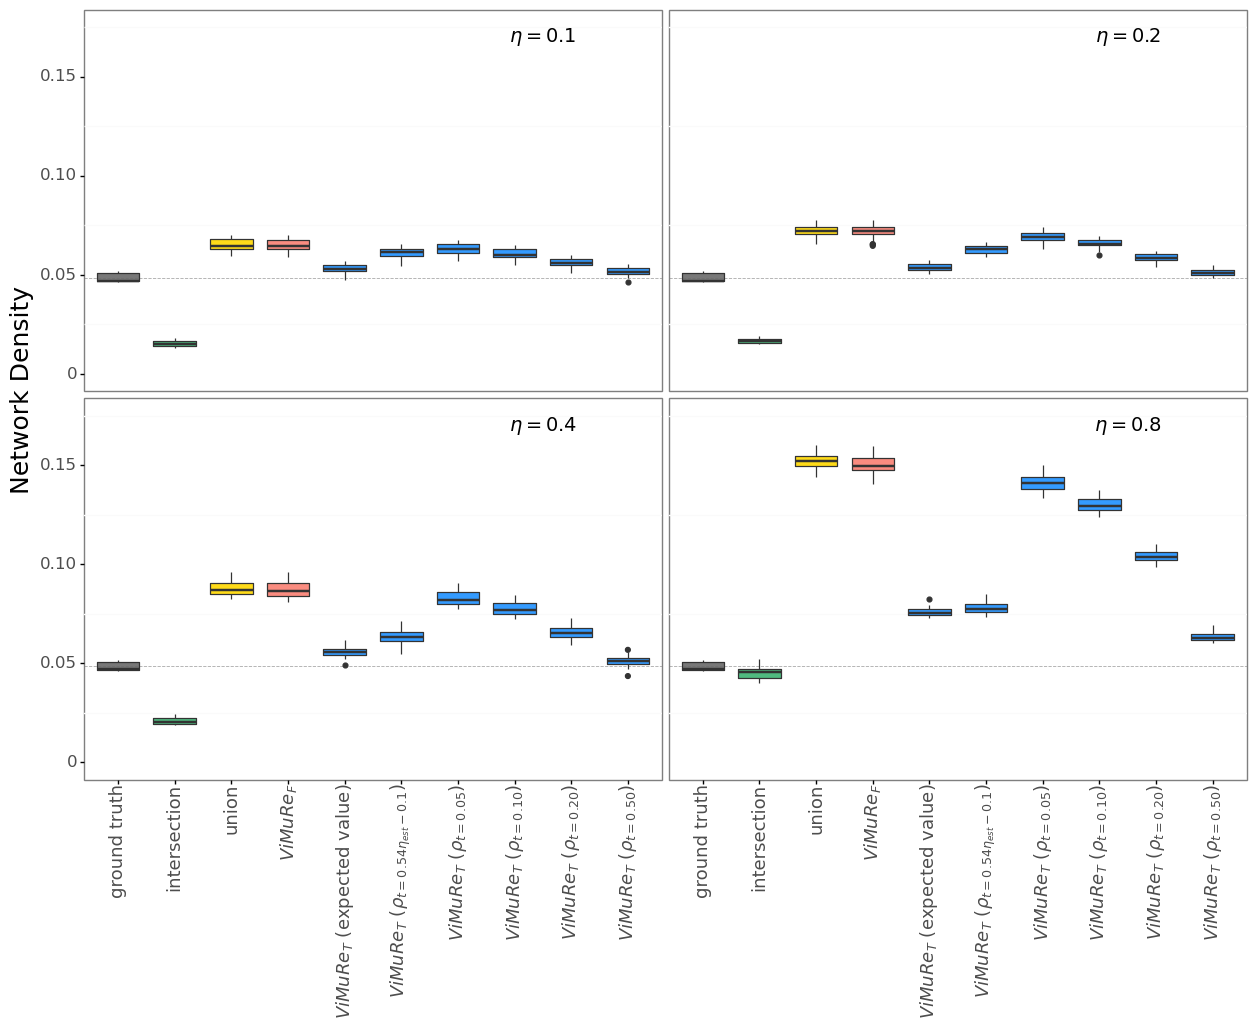

<ggplot: (8767592910273)>

In [143]:
results2_df = pd.DataFrame(clf.cv_results_)

cols = results2_df.columns
selected_cols = [col for col in cols if "mean_train_reciprocity" in col]

group_cols = ["param_reciprocity_Y", 
              "param_planted_mutuality",
              "param_vimure_mutuality"   ]

main_metric = "density" # Options: "AUC", "F1" and "reciprocity" 

metrics = [col for col in results2_df.columns if ("mean_train" in col) and ((main_metric in col))]

# All the relevant columns we want to use in our plots
all_cols = group_cols + metrics


plot_df = results2_df[all_cols].copy()
plot_df["param_planted_mutuality"] = plot_df["param_planted_mutuality"].apply(lambda x: np.round(x, 2)).astype(str)
plot_df["param_reciprocity_Y"] = plot_df["param_reciprocity_Y"].apply(lambda x: np.round(x, 2)).astype(str)
plot_df["param_vimure_mutuality"] = \
    plot_df["param_vimure_mutuality"].apply(lambda x: r"$ViMuRe_{T}$" if x else r"$ViMuRe_{F}$")

plot_df = plot_df.rename(columns=columns_map)
plot_df = pd.melt(plot_df, id_vars=[columns_map[col] for col in group_cols])

def group_decider(row):
    if row["variable"] in ["ground truth", "union", "intersection"]:
        return row["variable"]
    elif row["model"] == r"$ViMuRe_{F}$":
        return row["model"]
    else:
        return row["model"] + " " + row["variable"]
    
def color_group_decider(row):
    if row["variable"] in ["ground truth", "union", "intersection"]:
        return row["variable"]
    else:
        return row["model"]
    
X_group_categories = ["ground truth", "intersection", "union"]
    
if main_metric == "AUC":
    X_group_categories = X_group_categories + [ r"$ViMuRe_{F}$" + " | " + r"AUC (on Y)",
                                                r"$ViMuRe_{F}$" + " | " + r"AUC (on X)",
                                                r"$ViMuRe_{T}$" + " | " + r"AUC (on Y)",
                                                r"$ViMuRe_{T}$" + " | " + r"AUC (on X)"]
elif main_metric == "F1":
    X_group_categories = X_group_categories + [ r"$ViMuRe_{F}$" + " | " + r"AUC (on Y)",
                                                r"$ViMuRe_{F}$" + " | " + r"AUC (on X)",
                                                r"$ViMuRe_{T}$" + " | " + r"AUC (on Y)",
                                                r"$ViMuRe_{T}$" + " | " + r"AUC (on X)"]
elif main_metric == "reciprocity" or main_metric == "density":
    X_group_categories = X_group_categories + [r"$ViMuRe_{F}$",
                                               r"$ViMuRe_{T}$" + " " + r"(expected value)", 
                                               r"$ViMuRe_{T}$" + " " + r"($\rho_{t=0.54\eta_{est} - 0.1}$)", 
                                               r"$ViMuRe_{T}$" + " " + r"($\rho_{t=0.05}$)",
                                               r"$ViMuRe_{T}$" + " " + r"($\rho_{t=0.10}$)",
                                               r"$ViMuRe_{T}$" + " " + r"($\rho_{t=0.20}$)",
                                               r"$ViMuRe_{T}$" + " " + r"($\rho_{t=0.50}$)"]

plot_df["X_group"] = pd.Categorical(plot_df.apply(group_decider, axis=1), categories=X_group_categories)

plot_df["color_group"] = pd.Categorical(plot_df.apply(color_group_decider, axis=1), 
                                        categories=["ground truth", "intersection", "union", r"$ViMuRe_{F}$", r"$ViMuRe_{T}$"])

selected_reciprocities = ["0.1", "0.2", "0.4", "0.8"]

# selected_y_reciprocity = '0.4'

aux_df = pd.concat([plot_df.query("reciprocity_Y == '0.2' & mutuality_X == '%s'" % (selected_y_reciprocity)) 
                           for selected_y_reciprocity in selected_reciprocities])
# aux_df = aux_df[aux_df["X_group"] != r"$ViMuRe_{F}$"]

annotation_df = aux_df.groupby(["mutuality_X"])[["value"]].max().reset_index()
annotation_df["value"] = 0.17
annotation_df["X_group"] = 8.5
annotation_df["color_group"] = None
annotation_df["eta_annotation"] = annotation_df["mutuality_X"].apply(lambda x: r"$\eta = %s$" % x) 

# Ground truth average line
gt_line_df = aux_df[aux_df["variable"] == "ground truth"].groupby(["reciprocity_Y", "mutuality_X", "variable"])[["value"]].mean().reset_index()


g = (ggplot(aux_df, 
            aes(x="X_group", 
                y="value",
                fill="color_group")) +
     geom_hline(aes(yintercept="value"), data=gt_line_df, linetype="dashed", color="tab:gray", size=0.35, alpha=0.65) +
     geom_boxplot(position="dodge", alpha=0.9) + 
     scale_fill_manual(name="Model Type",
                       values={"ground truth": "dimgrey",
                               "union": "gold",
                               "intersection": "mediumseagreen",
                               r"$ViMuRe_{F}$": "salmon",
                               r"$ViMuRe_{T}$": "dodgerblue"},
                      guide=False) +
     theme_bw() + 
     theme(figure_size=(15, 10),
           axis_text_x=element_text(rotation=90, margin={'b': 30, 'r': 5}, size=13),
           axis_text_y=element_text(size=12),
           panel_grid_major=element_blank(),
           strip_background = element_blank(),
           strip_text_x = element_blank(),
           axis_title_y=element_text(size=18),
           legend_position = (9, 0.6),
           legend_background = element_rect(fill = "white", colour = None),
           legend_direction="vertical") +
     geom_text(aes(label="eta_annotation"), data=annotation_df, size=14, color="black") +
     scale_x_discrete(name="", breaks=X_group_categories) +
     scale_y_continuous(name="Network Density", limits=(0, 0.175)) +
     facet_wrap(" ~ mutuality_X", labeller=None, ncol=2) #+ 
#      ggtitle("Comparison of network density")
    )

save_filename = "/mnt/data/metric_%s_fixed_reciprocity_Y.pdf" % (main_metric)

# ggsave(g, filename=save_filename, dpi=300)

g

In [145]:
results2_df.to_csv("/mnt/data/exp_varying_reciprocity.csv", index=False)

# Key takeaways from these new synthetic experiments

- Binarized results of $ViMuRe_{T}$ are sensitive to thresholding on $\rho$ 

- Our simulations with `planted_reciprocity=0.2` and varied mutuality, shows a heuristic way to set this result and achieve the reciprocity values found in the ground truth $Y$ matrix. After running $ViMuRe_{T}$, we can post-process $\rho$ by applying the threshold:

$$
t* = 0.54 \eta_{est} - 0.01
$$